# Using TensorFlow Object Detection API with OpenVINO™

[TensorFlow](https://www.tensorflow.org/), or TF for short, is an open-source framework for machine learning.

The [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) is an open-source computer vision framework built on top of TensorFlow. It is used for building object detection and instance segmentation models that can localize multiple objects in the same image. TensorFlow Object Detection API supports various architectures and models, which can be found and downloaded from the [TensorFlow Hub](https://tfhub.dev/tensorflow/collections/object_detection/1).

This tutorial shows how to perform both task with OpenVINO Runtime. We will consider TensorFlow [Faster R-CNN with Resnet-50 V1](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1) object detection model and [Mask R-CNN with Inception ResNet V2](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1) instance segmentation model. We present how to convert both models to OpenVINO [Intermediate Representation](https://docs.openvino.ai/2024/documentation/openvino-ir-format/operation-sets.html) (OpenVINO IR) format, using Model Converter. After creating the OpenVINO IR, we show how to load models in [OpenVINO Runtime](https://docs.openvino.ai/2024/openvino-workflow/running-inference.html) and do inference with a sample image.


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Imports](#Imports)
- [Prepare input data](#Prepare-input-data)
- [Object Detection](#Object-Detection)
    - [Download Model from TensorFlow Hub](#Download-Model-from-TensorFlow-Hub)
    - [Convert Model to OpenVINO IR](#Convert-Model-to-OpenVINO-IR)
    - [Select inference device](#Select-inference-device)
    - [Load the Model](#Load-the-Model)
    - [Get Model Information](#Get-Model-Information)
    - [Perform Inference](#Perform-Inference)
    - [Inference Result Visualization](#Inference-Result-Visualization)
- [Instance Segmentation](#Instance-Segmentation)
    - [Download Model from TensorFlow Hub](#Download-Model-from-TensorFlow-Hub)
    - [Convert Model to OpenVINO IR](#Convert-Model-to-OpenVINO-IR)
    - [Load the Model](#Load-the-Model)
    - [Get Model Information](#Get-Model-Information)
    - [Perform Inference](#Perform-Inference)
    - [Inference Result Visualization](#Inference-Result-Visualization)
- [Next Steps](#Next-Steps)
    - [Async inference pipeline](#Async-inference-pipeline)
    - [Integration preprocessing to model](#Integration-preprocessing-to-model)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/tensorflow-object-detection-to-openvino/tensorflow-object-detection-api-with-openvino.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages:

In [1]:
%pip install -q "openvino>=2023.1.0" "numpy>=1.21.0" "opencv-python" "tqdm"

%pip install -q "matplotlib>=3.4"
%pip install -q "tensorflow-macos>=2.5; sys_platform == 'darwin' and platform_machine == 'arm64'" # macOS M1 and M2
%pip install -q "tensorflow>=2.5; sys_platform == 'darwin' and platform_machine != 'arm64'" # macOS x86
%pip install -q "tensorflow>=2.5; sys_platform != 'darwin'"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 14.0 MB/s eta 0:00:00


The notebook uses utility functions.
The cell below will download the `notebook_utils` Python module from GitHub.

In [29]:
# Fetch the notebook utils script from the openvino_notebooks repo
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("tensorflow-object-detection-api-with-openvino.ipynb")

## Imports
[back to top ⬆️](#Table-of-contents:)


In [3]:
# Standard python modules
from pathlib import Path

# External modules and dependencies
import cv2
import matplotlib.pyplot as plt
import numpy as np

# OpenVINO import
import openvino as ov

# Notebook utils module
from notebook_utils import download_file, device_widget

## Prepare input data
[back to top ⬆️](#Table-of-contents:)

Load and save an image:

In [4]:
image_path = Path("./data/coco_bike.jpg")

if not image_path.exists():
    download_file(
        url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
        filename=image_path.name,
        directory=image_path.parent,
    )

coco_bike.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

Read the image, resize and convert it to the input shape of the network:

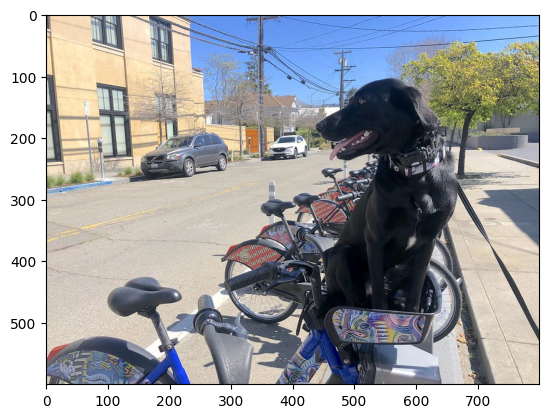

In [5]:
# Read the image
image = cv2.imread(filename=str(image_path))

# The network expects images in RGB format
image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape
resized_image = cv2.resize(src=image, dsize=(255, 255))

# Add batch dimension to image
network_input_image = np.expand_dims(resized_image, 0)

# Show the image
plt.imshow(image)

Import functions which help to visualize results.

In [6]:
if not Path("visualization_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/tensorflow-object-detection-to-openvino/visualization_helper.py"
    )
    open("visualization_helper.py", "w").write(r.text)

from visualization_helper import visualize_inference_result

TensorFlow Object Detection model ([faster_rcnn_resnet50_v1_640x640](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1)) used in this notebook was trained on [COCO 2017](https://cocodataset.org/) dataset with 91 classes.
For better visualization experience we can use COCO dataset labels with human readable class names instead of class numbers or indexes.

We can download COCO dataset classes labels from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/):

In [7]:
coco_labels_file_path = Path("./data/coco_91cl.txt")

if not coco_labels_file_path.exists():
    download_file(
        url="https://raw.githubusercontent.com/openvinotoolkit/open_model_zoo/master/data/dataset_classes/coco_91cl.txt",
        filename=coco_labels_file_path.name,
        directory=coco_labels_file_path.parent,
    )

coco_91cl.txt:   0%|          | 0.00/421 [00:00<?, ?B/s]

Then we need to create dictionary `coco_labels_map` with mappings between detection classes numbers and its names from the downloaded file:

In [8]:
with open(coco_labels_file_path, "r") as file:
    coco_labels = file.read().strip().split("\n")
    coco_labels_map = dict(enumerate(coco_labels, 1))

print(coco_labels_map)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplan', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'street sign', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'plate', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'mirror', 67: 'dining table', 68: 'window', 69: 'des

Now let's move on to looking at the models and how they work with OpenVINO Runtime.

## Object Detection
[back to top ⬆️](#Table-of-contents:)

Define model related variables and create corresponding directories. We will execute TensorFlow [Faster R-CNN with Resnet-50 V1](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1) object detection model.

In [9]:
# Create directories for models files
model_dir = Path("od-model")
model_dir.mkdir(exist_ok=True)

# Create directory for TensorFlow model
tf_model_dir = model_dir / "tf"
tf_model_dir.mkdir(exist_ok=True)

# Create directory for OpenVINO IR model
ir_model_dir = model_dir / "ir"
ir_model_dir.mkdir(exist_ok=True)

model_name = "faster_rcnn_resnet50_v1_640x640"

openvino_ir_path = ir_model_dir / f"{model_name}.xml"

tf_model_url = "https://www.kaggle.com/models/tensorflow/faster-rcnn-resnet-v1/frameworks/tensorFlow2/variations/faster-rcnn-resnet50-v1-640x640/versions/1?tf-hub-format=compressed"

tf_model_archive_filename = f"{model_name}.tar.gz"

### Download Model from TensorFlow Hub
[back to top ⬆️](#Table-of-contents:)

Download archive with TensorFlow Object Detection model ([faster_rcnn_resnet50_v1_640x640](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1)) from TensorFlow Hub:

In [10]:
download_file(url=tf_model_url, filename=tf_model_archive_filename, directory=tf_model_dir)

faster_rcnn_resnet50_v1_640x640.tar.gz:   0%|          | 0.00/101M [00:00<?, ?B/s]

PosixPath('/content/od-model/tf/faster_rcnn_resnet50_v1_640x640.tar.gz')

Extract TensorFlow Object Detection model from the downloaded archive:

In [11]:
import tarfile

with tarfile.open(tf_model_dir / tf_model_archive_filename) as file:
    file.extractall(path=tf_model_dir)

### Convert Model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

OpenVINO Model Conversion API can be used to convert the TensorFlow model to OpenVINO IR.

`ov.convert_model` function accept path to TensorFlow model and returns OpenVINO Model class instance which represents this model.
Also we need to provide model input shape (`input_shape`) that is described at [model overview page on TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1).

The converted model is ready to load on a device using `compile_model` or saved on disk using the `save_model` function to reduce loading time when the model is run in the future.

See the [Model Preparation Guide](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html) for more information about model conversion and TensorFlow [models support](https://docs.openvino.ai/2024/openvino-workflow/model-preparation/convert-model-tensorflow.html).

In [12]:
ov_model = ov.convert_model(tf_model_dir)

# Save converted OpenVINO IR model to the corresponding directory
ov.save_model(ov_model, openvino_ir_path)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [13]:
core = ov.Core()
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Load the Model
[back to top ⬆️](#Table-of-contents:)


In [14]:
core = ov.Core()
openvino_ir_model = core.read_model(openvino_ir_path)
compiled_model = core.compile_model(model=openvino_ir_model, device_name=device.value)

### Get Model Information
[back to top ⬆️](#Table-of-contents:)

Faster R-CNN with Resnet-50 V1 object detection model has one input - a three-channel image of variable size. The input tensor shape is `[1, height, width, 3]` with values in `[0, 255]`.

Model output dictionary contains several tensors:

- `num_detections` - the number of detections in `[N]` format.
- `detection_boxes` - bounding box coordinates for all `N` detections in `[ymin, xmin, ymax, xmax]` format.
- `detection_classes` - `N` detection class indexes size from the label file.
- `detection_scores` - `N` detection scores (confidence) for each detected class.
- `raw_detection_boxes` - decoded detection boxes without Non-Max suppression.
- `raw_detection_scores` - class score logits for raw detection boxes.
- `detection_anchor_indices` - the anchor indices of the detections after NMS.
- `detection_multiclass_scores` - class score distribution (including background) for detection boxes in the image including background class.

In this tutorial we will mostly use `detection_boxes`, `detection_classes`, `detection_scores` tensors. It is important to mention, that values of these tensors correspond to each other and are ordered by the highest detection score: the first detection box corresponds to the first detection class and to the first (and highest) detection score.

See the [model overview page on TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1) for more information about model inputs, outputs and their formats.

In [15]:
model_inputs = compiled_model.inputs
model_input = compiled_model.input(0)
model_outputs = compiled_model.outputs

print("Model inputs count:", len(model_inputs))
print("Model input:", model_input)

print("Model outputs count:", len(model_outputs))
print("Model outputs:")
for output in model_outputs:
    print("  ", output)

Model inputs count: 1
Model input: <ConstOutput: names[input_tensor] shape[1,?,?,3] type: u8>
Model outputs count: 8
Model outputs:
   <ConstOutput: names[detection_anchor_indices] shape[1,?] type: f32>
   <ConstOutput: names[detection_boxes] shape[1,?,..8] type: f32>
   <ConstOutput: names[detection_classes] shape[1,?] type: f32>
   <ConstOutput: names[detection_multiclass_scores] shape[1,?,..182] type: f32>
   <ConstOutput: names[detection_scores] shape[1,?] type: f32>
   <ConstOutput: names[num_detections] shape[1] type: f32>
   <ConstOutput: names[raw_detection_boxes] shape[1,300,4] type: f32>
   <ConstOutput: names[raw_detection_scores] shape[1,300,91] type: f32>


### Perform Inference
[back to top ⬆️](#Table-of-contents:)


In [16]:
inference_result = compiled_model(network_input_image)

After model inference on the test image, object detection data can be extracted from the result.
For further model result visualization `detection_boxes`, `detection_classes` and `detection_scores` outputs will be used.

In [17]:
(
    _,
    detection_boxes,
    detection_classes,
    _,
    detection_scores,
    num_detections,
    _,
    _,
) = model_outputs

image_detection_boxes = inference_result[detection_boxes]
print("image_detection_boxes:", image_detection_boxes)

image_detection_classes = inference_result[detection_classes]
print("image_detection_classes:", image_detection_classes)

image_detection_scores = inference_result[detection_scores]
print("image_detection_scores:", image_detection_scores)

image_num_detections = inference_result[num_detections]
print("image_detections_num:", image_num_detections)

# Alternatively, inference result data can be extracted by model output name with `.get()` method
assert (inference_result[detection_boxes] == inference_result.get("detection_boxes")).all(), "extracted inference result data should be equal"

image_detection_boxes: [[[0.16447833 0.5460326  0.89537144 0.8550827 ]
  [0.6717681  0.01238852 0.9843284  0.5311336 ]
  [0.49202633 0.01172762 0.98052186 0.8866133 ]
  ...
  [0.46021438 0.5924625  0.48734403 0.6187243 ]
  [0.4360505  0.59333974 0.4692526  0.63410085]
  [0.68998176 0.41356683 0.9760198  0.8143898 ]]]
image_detection_classes: [[18.  2.  2.  3.  2.  8.  2.  2.  3.  2.  4.  4.  2.  4. 16.  1.  1.  2.
  27.  8. 62.  2.  2.  4.  4.  2. 18. 41.  4.  4.  2. 18.  2.  2.  4.  2.
  27.  2. 27.  2.  1.  2. 16.  1. 16.  2.  2.  2.  2. 16.  2.  2.  4.  2.
   1. 33.  4. 15.  3.  2.  2.  1.  2.  1.  4.  2. 11.  3.  4. 35.  4.  1.
  40.  2. 62.  2.  4.  4. 36.  1. 36. 36. 77. 31.  2.  1. 51.  1. 34.  3.
  90.  3.  2.  2.  1.  2.  2.  1.  1.  1.  2. 18.  4.  3.  2.  2. 31.  1.
   2.  1.  2. 41. 33. 41. 31.  3.  3.  1. 36. 15. 27.  4. 27.  2.  4. 15.
   3. 37.  1. 27.  4. 35. 36. 88.  4.  2.  3. 15.  2.  4.  2.  1.  3. 27.
   4.  3.  4. 16. 23. 44.  1.  1.  4.  1.  4.  3. 15.  4. 62. 36

### Inference Result Visualization
[back to top ⬆️](#Table-of-contents:)

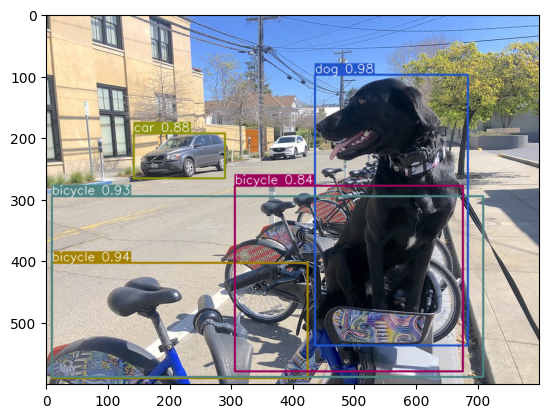

In [18]:
visualize_inference_result(
    inference_result=inference_result,
    image=image,
    labels_map=coco_labels_map,
    detections_limit=5,
)

## Instance Segmentation
[back to top ⬆️](#Table-of-contents:)


Define model related variables and create corresponding directories. We will execute TensorFlow [Mask R-CNN with Inception ResNet V2](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1) instance segmentation model.

In [19]:
# Create directories for models files
model_dir = Path("is-model")
model_dir.mkdir(exist_ok=True)

# Create directory for TensorFlow model
tf_model_dir = model_dir / "tf"
tf_model_dir.mkdir(exist_ok=True)

# Create directory for OpenVINO IR model
ir_model_dir = model_dir / "ir"
ir_model_dir.mkdir(exist_ok=True)

model_name = "mask_rcnn_inception_resnet_v2_1024x1024"

openvino_ir_path = ir_model_dir / f"{model_name}.xml"

tf_model_url = (
    "https://www.kaggle.com/models/tensorflow/mask-rcnn-inception-resnet-v2/frameworks/tensorFlow2/variations/1024x1024/versions/1?tf-hub-format=compressed"
)

tf_model_archive_filename = f"{model_name}.tar.gz"

### Download Model from TensorFlow Hub
[back to top ⬆️](#Table-of-contents:)

Download archive with TensorFlow Instance Segmentation model ([mask_rcnn_inception_resnet_v2_1024x1024](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1)) from TensorFlow Hub:

In [20]:
if not (tf_model_dir / tf_model_archive_filename).exists():
    download_file(url=tf_model_url, filename=tf_model_archive_filename, directory=tf_model_dir)

mask_rcnn_inception_resnet_v2_1024x1024.tar.gz:   0%|          | 0.00/232M [00:00<?, ?B/s]

Extract TensorFlow Instance Segmentation model from the downloaded archive:

In [21]:
import tarfile

with tarfile.open(tf_model_dir / tf_model_archive_filename) as file:
    file.extractall(path=tf_model_dir)

### Convert Model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

We will also use OpenVINO Model Optimizer Python API to convert the TensorFlow model to OpenVINO IR. We run `mo.convert_model` with path to TensorFlow model and get OpenVINO Model class instance which represents this model. After that we save model on disc via `ov.save_model`.

In [22]:
ov_model = ov.convert_model(tf_model_dir)

# Save converted OpenVINO IR model to the corresponding directory
ov.save_model(ov_model, openvino_ir_path)

### Load the Model
[back to top ⬆️](#Table-of-contents:)

In [23]:
openvino_ir_model = core.read_model(openvino_ir_path)
compiled_model = core.compile_model(model=openvino_ir_model, device_name=device.value)

### Get Model Information
[back to top ⬆️](#Table-of-contents:)

Mask R-CNN with Inception ResNet V2 instance segmentation model has one input - a three-channel image of variable size. The input tensor shape is `[1, height, width, 3]` with values in `[0, 255]`.

Model output dictionary contains a lot of tensors, we will use only 5 of them:
- `num_detections`: A `tf.int` tensor with only one value, the number of detections `[N]`.
- `detection_boxes`: A `tf.float32` tensor of shape `[N, 4]` containing bounding box coordinates in the following order: `[ymin, xmin, ymax, xmax]`.
- `detection_classes`: A `tf.int` tensor of shape `[N]` containing detection class index from the label file.
- `detection_scores`: A `tf.float32` tensor of shape `[N]` containing detection scores.
- `detection_masks`: A `[batch, max_detections, mask_height, mask_width]` tensor. Note that a pixel-wise sigmoid score converter is applied to the detection masks.

For more information about model inputs, outputs and their formats, see the [model overview page on TensorFlow Hub](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1).

It is important to mention, that values of `detection_boxes`, `detection_classes`, `detection_scores`, `detection_masks` correspond to each other and are ordered by the highest detection score: the first detection mask corresponds to the first detection class and to the first (and highest) detection score.

In [24]:
model_inputs = compiled_model.inputs
model_outputs = compiled_model.outputs

print("Model inputs count:", len(model_inputs))
print("Model inputs:")
for _input in model_inputs:
    print("  ", _input)

print("Model outputs count:", len(model_outputs))
print("Model outputs:")
for output in model_outputs:
    print("  ", output)

Model inputs count: 1
Model inputs:
   <ConstOutput: names[input_tensor] shape[1,?,?,3] type: u8>
Model outputs count: 23
Model outputs:
   <ConstOutput: names[anchors] shape[49152,4] type: f32>
   <ConstOutput: names[box_classifier_features] shape[300,9,9,1536] type: f32>
   <ConstOutput: names[image_shape] shape[4] type: f32>
   <ConstOutput: names[mask_predictions] shape[100,90,33,33] type: f32>
   <ConstOutput: names[num_detections] shape[1] type: f32>
   <ConstOutput: names[num_proposals] shape[1] type: f32>
   <ConstOutput: names[proposal_boxes] shape[1,?,..8] type: f32>
   <ConstOutput: names[final_anchors, proposal_boxes_normalized] shape[1,?,..8] type: f32>
   <ConstOutput: names[raw_detection_boxes] shape[1,300,4] type: f32>
   <ConstOutput: names[raw_detection_scores] shape[1,300,91] type: f32>
   <ConstOutput: names[refined_box_encodings] shape[300,90,4] type: f32>
   <ConstOutput: names[rpn_box_encodings] shape[1,49152,4] type: f32>
   <ConstOutput: names[class_predictions

### Perform Inference
[back to top ⬆️](#Table-of-contents:)

In [25]:
inference_result = compiled_model(network_input_image)

After model inference on the test image, instance segmentation data can be extracted from the result.
For further model result visualization `detection_boxes`, `detection_masks`, `detection_classes` and `detection_scores` outputs will be used.

In [26]:
detection_boxes = compiled_model.output("detection_boxes")
image_detection_boxes = inference_result[detection_boxes]
print("image_detection_boxes:", image_detection_boxes.shape)

detection_masks = compiled_model.output("detection_masks")
image_detection_masks = inference_result[detection_masks]
print("image_detection_masks:", image_detection_masks.shape)

detection_classes = compiled_model.output("detection_classes")
image_detection_classes = inference_result[detection_classes]
print("image_detection_classes:", image_detection_classes.shape)

detection_scores = compiled_model.output("detection_scores")
image_detection_scores = inference_result[detection_scores]
print("image_detection_scores:", image_detection_scores.shape)

num_detections = compiled_model.output("num_detections")
image_num_detections = inference_result[num_detections]
print("image_detections_num:", image_num_detections)

# Alternatively, inference result data can be extracted by model output name with `.get()` method
assert (inference_result[detection_boxes] == inference_result.get("detection_boxes")).all(), "extracted inference result data should be equal"

image_detection_boxes: (1, 100, 4)
image_detection_masks: (1, 100, 33, 33)
image_detection_classes: (1, 100)
image_detection_scores: (1, 100)
image_detections_num: [100.]


### Inference Result Visualization
[back to top ⬆️](#Table-of-contents:)

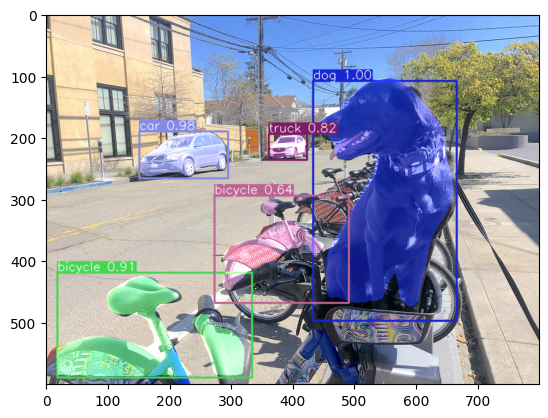

In [27]:
visualize_inference_result(
    inference_result=inference_result,
    image=image,
    labels_map=coco_labels_map,
    detections_limit=5,
)

## Next Steps
[back to top ⬆️](#Table-of-contents:)

This section contains suggestions on how to additionally improve the performance of your application using OpenVINO.

### Async inference pipeline
[back to top ⬆️](#Table-of-contents:)
The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to the [Async API tutorial](../async-api/async-api.ipynb).

### Integration preprocessing to model
[back to top ⬆️](#Table-of-contents:)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries.
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will improve selected device utilization.

For more information, refer to the [Optimize Preprocessing tutorial](../optimize-preprocessing/optimize-preprocessing.ipynb) and to the overview of [Preprocessing API](https://docs.openvino.ai/2024/openvino-workflow/running-inference/optimize-inference/optimize-preprocessing/preprocessing-api-details.html).
